   id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4

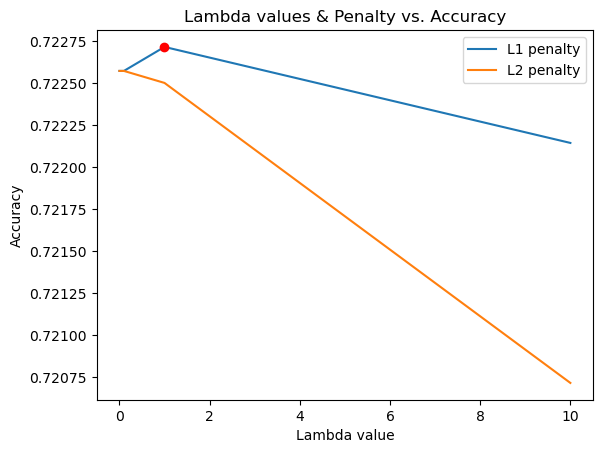

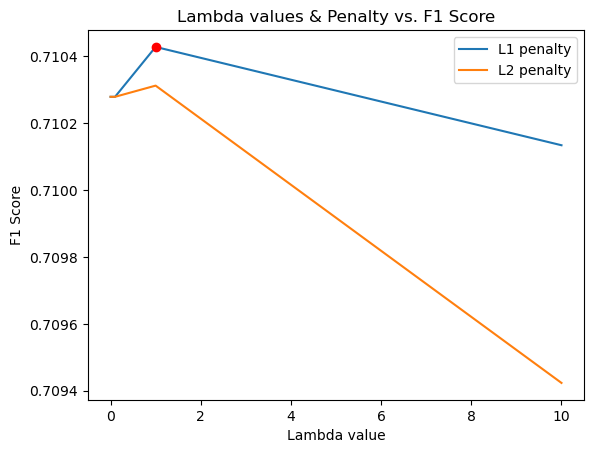

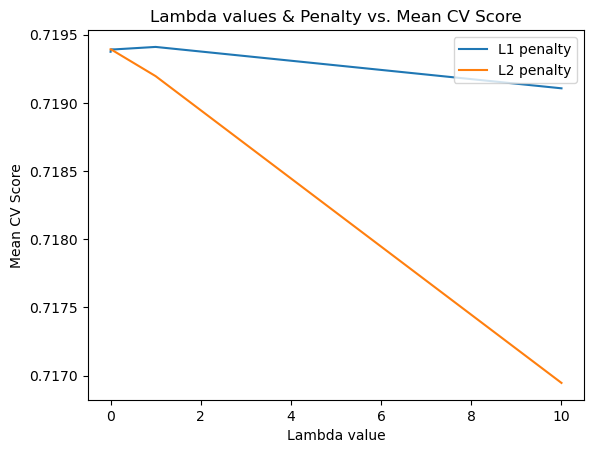

In [25]:
#imports
from sklearn import svm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import itertools
from sklearn import model_selection
import random
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
random.seed(42)

#loading the data set
data = pd.read_csv('cardio_train.csv', sep = ';')
data_copy = data

##############################checking data set##################################

print(data.head())

#check data types
print(data.info())

#############################data preprocessing##################################

#check for null values
null_rows = data[data.isnull().any(axis=1)].head()
print(null_rows.head()) #-->no null values 

#check whether data set is balanced
sick = data['cardio'].value_counts()[1]
healthy = len(data) - data['cardio'].value_counts()[1]
print("sick: ", sick, "individuals; healthy: ", healthy, "individuals\n")

#check correlations
data_corr = data_copy.drop(columns=['gender', 'cholesterol', 'gluc','smoke','alco','active'])
print(data_corr.corr()['cardio'])

data_target = data['cardio']

#dropping the label column & id
data = data.drop(columns=['cardio','id','height'])

#convert age to years so we can interpret it better

data['age'] = data['age'] / 365


#one-hot encoding the categorical features & normalizing the numerical features

numerical_features = ['age','weight', 'ap_hi', 'ap_lo']
categorical_features = ['gender', 'cholesterol', 'gluc','smoke',
                        'alco','active']
full_pipeline = ColumnTransformer([
    ("num", StandardScaler(), numerical_features),
     ("cat", OneHotEncoder(), categorical_features)
    ])

data = full_pipeline.fit_transform(data)

################################training & testing#########################################

#splitting the data for training & testing
train, test, target, target_test = train_test_split(data, data_target, test_size = 0.2, random_state = 42)

#testing all lambda values & regularization combos

lambda_values = [0.001,0.01, 0.1, 1, 10]

accuracies_l1 = []
accuracies_l2 = []
f1_l1 = []
f1_l2 = []

#L1 regularization & different lambda values
for l in lambda_values:
    logisticRegr = LogisticRegression(penalty = 'l1', solver = 'liblinear', C = 1/l)
    logisticRegr.fit(train, target)
    log_predicted = logisticRegr.predict(test)
    log_score = logisticRegr.predict_proba(test)[:,1]
    #plot_roc_curve(target_test, log_score)
    accuracies_l1.append(metrics.accuracy_score(target_test, log_predicted))
    print("lambda = ", l, " penalty = l1 - ",metrics.accuracy_score(target_test, log_predicted))
    print()
    f1_l1.append(metrics.f1_score(target_test, log_predicted, labels=None, pos_label=1, average='binary', sample_weight=None))

#L2 regularization & different lambda values
for l in lambda_values:
    logisticRegr = LogisticRegression(penalty='l2', C = 1/l)
    logisticRegr.fit(train, target)
    log_predicted = logisticRegr.predict(test)
    log_score = logisticRegr.predict_proba(test)[:,1]
    #plot_roc_curve(target_test, log_score)
    accuracies_l2.append(metrics.accuracy_score(target_test, log_predicted))
    print("lambda = ", l, " penalty = l2 - ", metrics.accuracy_score(target_test, log_predicted))
    print()
    f1_l2.append(metrics.f1_score(target_test, log_predicted, labels=None, pos_label=1, average='binary', sample_weight=None))

#no penalty
print("penalty = None")
logisticRegr = LogisticRegression(penalty = None)
logisticRegr.fit(train, target)
log_predicted = logisticRegr.predict(test)
log_score = logisticRegr.predict_proba(test)[:,1]
score = metrics.accuracy_score(target_test, log_predicted)

#visualizations
x = lambda_values
x_plot = 1
y_plot = accuracies_l1[3]
y = accuracies_l1
y_l2 = accuracies_l2
plt.plot(x,y, label = 'L1 penalty')
plt.plot(x,y_l2, label = 'L2 penalty')
plt.legend(loc="upper right")
plt.xlabel("Lambda value")
plt.ylabel("Accuracy")
plt.title("Lambda values & Penalty vs. Accuracy")
plt.plot(x_plot, y_plot, 'o', color = 'red')
plt.show()

#visualizations
x = lambda_values
x_plot = 1
y_plot = f1_l1[3]
y = f1_l1
y_l2 = f1_l2
plt.plot(x,y, label = 'L1 penalty')
plt.plot(x,y_l2, label = 'L2 penalty')
plt.legend(loc="upper right")
plt.xlabel("Lambda value")
plt.ylabel("F1 Score")
plt.title("Lambda values & Penalty vs. F1 Score")
plt.plot(x_plot, y_plot, 'o', color = 'red')
plt.show()

#############################k-fold cross validation for lambda & penalty w/ highest accuracy##################################

max_cv_l1 = []
max_cv_l2 = []

kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)

#l1
for l in lambda_values:
    log_model_kfold = LogisticRegression(penalty = 'l1', solver = 'liblinear', C = 1/l)
    log_results_kfold = model_selection.cross_val_score(log_model_kfold, train, target, cv=kfold)
    max_cv_l1.append(log_results_kfold.mean())

#l2
for l in lambda_values:
    log_model_kfold = LogisticRegression(penalty = 'l2', C = 1/l)
    log_results_kfold = model_selection.cross_val_score(log_model_kfold, train, target, cv=kfold)
    max_cv_l2.append(log_results_kfold.mean())

#visualizations
x = lambda_values
y = max_cv_l1
y_l2 = max_cv_l2
plt.plot(x,y, label = 'L1 penalty')
plt.plot(x,y_l2, label = 'L2 penalty')
plt.legend(loc="upper right")
plt.xlabel("Lambda value")
plt.ylabel("Mean CV Score")
plt.title("Lambda values & Penalty vs. Mean CV Score")
plt.show()